In [90]:
#Importation des libraries
import numpy as np 
import pandas as pd 
import string
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from gensim import parsing
import chardet
from sklearn import metrics
import itertools
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix,classification_report, roc_curve,auc, log_loss

import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
from collections import Counter
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

In [ ]:
# load data
import pandas as pd
df =pd.read_parquet("mails_spam_clean.parquet")
df.head()

### Preprocessing et exploration du dataset

In [106]:
#Vérifions s'il y'a des valeurs manquantes
df.isnull().sum()

body    0
Spam    0
dtype: int64

In [ ]:
df = df.replace([True,False],[1, 0])
df.head(5)

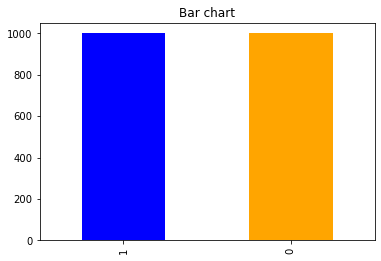

In [75]:
count_Class=pd.value_counts(df["Spam"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Spam / Ham')
plt.show()

In [108]:
count1 = Counter(" ".join(df[df['Spam']==0]["body"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "mails non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['Spam']==1]["body"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "mails spam", 1 : "count_"})

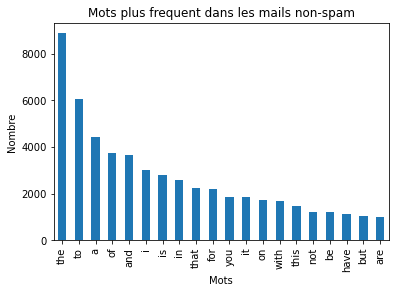

In [109]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["mails non-spam"]))
plt.xticks(y_pos, df1["mails non-spam"])
plt.title('Mots plus frequent dans les mails non-spam')
plt.xlabel('Mots')
plt.ylabel('Nombre')
plt.show()

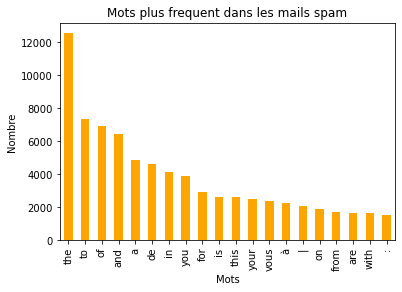

In [110]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["mails spam"]))
plt.xticks(y_pos, df2["mails spam"])
plt.title('Mots plus frequent dans les mails spam')
plt.xlabel('Mots')
plt.ylabel('Nombre')
plt.show()

De ces deux graphiques, nous constatons que le comptage du nombre de mots est un bon point de départ, mais est très basique.
Un problème est que certains mots comme « le » apparaîtront plusieurs fois et leur nombre élevé ne sera pas très significatif dans la classification de nos mails.       
Pour palier à ce problème nous pensons à la formule **TF*IDF**.

In [113]:
def parse(s):
    parsing.stem_text(s)
    return s

#applying parsing to comments.
for i in range(0,len(df)):
    df.iloc[i,0]=parse(df.iloc[i,0])
    df.iloc[i,0]=df.iloc[i,0].lower()
X, y = df['body'].tolist(), df['Spam'].tolist()

#Train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


- Count vectorizer crée une matrice de tous les mails où chaque valeur représente le nombre de fois que le mot correspondant apparaît dans ce mail.
On applique ensuite le Tfidf

La valeur de TF-IDF augmente proportionnellement au nombre de fois qu'un mot apparaît dans le document, et est compensée par la fréquence du mot dans la collection de documents, ce qui permet de gérer le fait que certains mots sont généralement plus courants que d'autres.

Ayant les caractéristiques représentées sous forme de vecteurs, nous pouvons enfin former notre classificateur de spam/ham avec n'importe quel algorithme de classification . Ici, nous utilisons les algorithmes suivants:

### Multinomiales Naives bayes classifier

Ensuite utiliser le pipeline pour effectuer des étapes en séquence avec un seul objet, cette fois nous utiliserons le classificateur Multinomial NB.

In [114]:
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

#Apprentissage du modèle sur les données d'apprentissage
text_clf.fit(X_train, y_train)

#prediction des données de test
predicted = text_clf.predict(X_test)

In [116]:
train_predictions = text_clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print("Log Loss: {}".format(ll))

# calculons l'AUC: Area under the curve(AUC) qui nous donne une idée du meilleur modèle:
y_pred = text_clf.predict(X_test)
auc_roc=metrics.roc_auc_score(y_test,y_pred)
print("auc_roc: {:.4%}".format(auc_roc))

acc=accuracy_score(y_test, predicted)
print("Accuracy: {:.4%}".format(acc))

cm=confusion_matrix(y_test, predicted)
#print(cm)

Log Loss: 0.1466429295365332
auc_roc: 96.8117%
Accuracy: 96.8182%
[[329  10]
 [ 11 310]]


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       339
           1       0.97      0.97      0.97       321

    accuracy                           0.97       660
   macro avg       0.97      0.97      0.97       660
weighted avg       0.97      0.97      0.97       660



Text(33.0, 0.5, 'Categorie Actuelle')

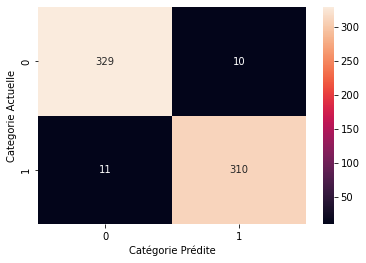

In [117]:
print(classification_report(y_test , predicted))
# creation du graphique de la matrice de confusion
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Catégorie Prédite')
plt.ylabel('Categorie Actuelle')

### Classification avec la regression logistique

In [118]:
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])

#train model
text_clf.fit(X_train, y_train)

#predict class form test data 
predicted = text_clf.predict(X_test)

In [120]:
train_predictions = text_clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print("Log Loss: {}".format(ll))

y_pred = text_clf.predict(X_test)
auc_roc=metrics.roc_auc_score(y_test,y_pred)
print("auc_roc: {:.4%}".format(auc_roc))

acc=accuracy_score(y_test, predicted)
print("Accuracy: {:.4%}".format(acc))

cm= confusion_matrix(y_test, predicted)
#print(cm)

Log Loss: 0.24162710669591006
auc_roc: 97.3038%
Accuracy: 97.2727%


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       339
           1       0.96      0.98      0.97       321

    accuracy                           0.97       660
   macro avg       0.97      0.97      0.97       660
weighted avg       0.97      0.97      0.97       660



Text(33.0, 0.5, 'Categorie Actuelle')

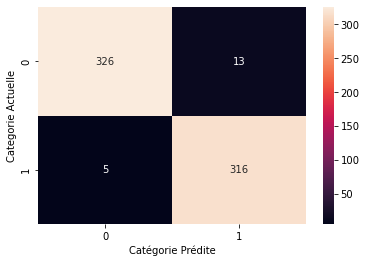

In [121]:
print(classification_report(y_test , predicted))
# creation du graphique de la matrice de confusion
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Catégorie Prédite')
plt.ylabel('Categorie Actuelle')

### SVM Polynomial Kernel

In [125]:
#Use pipeline to carry out steps in sequence with a single object, this time we'll use SVM classifier with polynomial kernel
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SVC(kernel='poly',probability=True))])

#train model
text_clf.fit(X_train, y_train)

#predict class form test data 
predicted = text_clf.predict(X_test)

In [129]:
train_predictions = text_clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print("Log Loss: {}".format(ll))

auc_roc=metrics.roc_auc_score(y_test,predicted)
print("auc_roc: {:.4%}".format(auc_roc))

acc=accuracy_score(y_test, predicted)
print("Accuracy: {:.4%}".format(acc))

cm=confusion_matrix(y_test, predicted)
print(cm)

Log Loss: 0.1432226929015338
auc_roc: 89.9085%
Accuracy: 90.1515%
[[335   4]
 [ 61 260]]


              precision    recall  f1-score   support

           0       0.85      0.99      0.91       339
           1       0.98      0.81      0.89       321

    accuracy                           0.90       660
   macro avg       0.92      0.90      0.90       660
weighted avg       0.91      0.90      0.90       660



Text(33.0, 0.5, 'Categorie Actuelle')

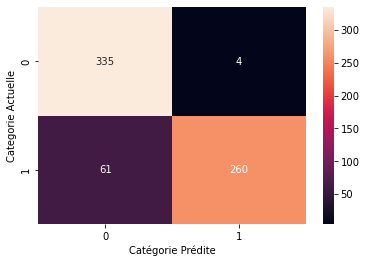

In [130]:
print(classification_report(y_test , predicted))
# creation du graphique de la matrice de confusion
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Catégorie Prédite')
plt.ylabel('Categorie Actuelle')

### SVM Linear Kernel

In [142]:
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SVC(kernel='linear',probability=True))])

#train model
text_clf.fit(X_train, y_train)

#predict class form test data 
predicted = text_clf.predict(X_test)

In [143]:
train_predictions = text_clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print("Log Loss: {}".format(ll))

auc_roc=metrics.roc_auc_score(y_test,predicted)
print("auc_roc: {:.4%}".format(auc_roc))

acc=accuracy_score(y_test, predicted)
print("Accuracy: {:.4%}".format(acc))

cm= confusion_matrix(y_test, predicted)
#print(cm)

Log Loss: 0.05316226756292627
auc_roc: 98.0578%
Accuracy: 98.0303%


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       339
           1       0.97      0.99      0.98       321

    accuracy                           0.98       660
   macro avg       0.98      0.98      0.98       660
weighted avg       0.98      0.98      0.98       660



Text(33.0, 0.5, 'Categorie Actuelle')

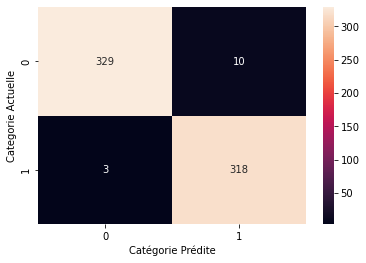

In [144]:
print(classification_report(y_test , predicted))
# creation du graphique de la matrice de confusion
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Catégorie Prédite')
plt.ylabel('Categorie Actuelle')

### Choix du modèle de classification

Accuracy:  0.9803030303030303


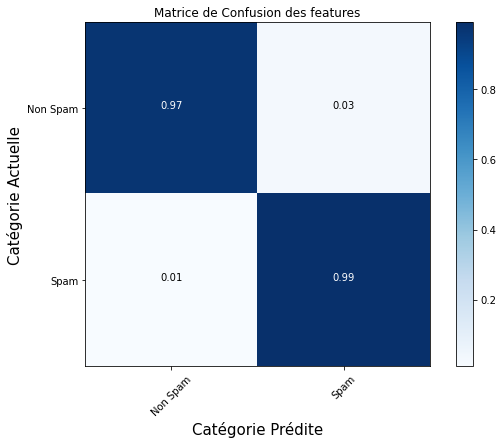

In [134]:
#Evaluation du classifier

# Fonction de construction de la matrice de confusion. 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Catégorie Actuelle',fontsize=15)
    plt.xlabel('Catégorie Prédite',fontsize=15)
    
    
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, predicted))

    
# Matrice de confusion du SVM Linear Kernel
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Non Spam','Spam'],normalize=True,
                      title='Matrice de Confusion des features')


### Probabilité de prédiction d'un mail Spam

In [135]:
y_prob = text_clf.predict_proba(X_test)
#y_prob[:,1]

#### Construction de la donnée de sortie

In [136]:
 #y_prob_2[0][1]*100
prob = pd.DataFrame()
#prob[["Ham_pred", "Spam_pred"]] = y_prob_2.T
prob["Ham_precision"],prob["Spam_precision"] = y_prob[:,0]*100, y_prob[:,1]*100
prob.head()

,Ham_precision,Spam_precision
0,96.604067,3.395933
1,0.813639,99.186361
2,99.985540,0.014460
3,99.577675,0.422325
4,0.443534,99.556466


In [138]:
y_prob[0][1]

0.03395932585806581

In [139]:
result1 = pd.DataFrame({'Mail':X_test})
pred = pd.DataFrame(y_pred, columns=['Category'])

res = result1.join(pred,how='inner')
res.head()

,Mail,Category
0,latest php upgrade in 7.3today an apt-get upg...,0
1,[spam] latifah exposed crotch weekly newsl...,1
2,"re: how do i fsck and xfs file system in ""sque...",0
3,re: authentication unsuccessful relaying from ...,0
4,for hibody. get 70% off today. commissioned s...,1


In [140]:
res_pr=res.join(prob)
res_pr.head()

res_pr['Ham_precision'] = res_pr['Ham_precision'].astype(float).round(2)
res_pr['Spam_precision'] = res_pr['Spam_precision'].astype(float).round(2)

res_pr.head()

,Mail,Category,Ham_precision,Spam_precision
0,latest php upgrade in 7.3today an apt-get upg...,0,96.60,3.40
1,[spam] latifah exposed crotch weekly newsl...,1,0.81,99.19
2,"re: how do i fsck and xfs file system in ""sque...",0,99.99,0.01
3,re: authentication unsuccessful relaying from ...,0,99.58,0.42
4,for hibody. get 70% off today. commissioned s...,1,0.44,99.56


In [141]:
res_pr.to_csv("prediction_finale_SVM.csv", index=False, sep=";",encoding='utf-8-sig')